# Walidacja tras karetek na bazie obiektów medycznych
W tym notatniku przeprowadzana jest dalsza filtracja i analiza tras karetek z uwzględnieniem informacji o pobliskich obiektach medycznych. Celem jest wykluczenie tras, które najprawdopodobniej nie są rzeczywistymi interwencjami ratunkowymi — w szczególności tych, które zaczynają się i kończą przy obiektach medycznych i nie mają żadnych przerw (postojów) po drodze. Notatnik klasyfikuje i wizualizuje różne typy tras w zależności od bliskości punktów początkowych i końcowych do obiektów medycznych oraz obecności postojów, co pozwala odróżnić potencjalne interwencje, przewozy pacjentów oraz niewiarygodne rekordy.

In [7]:
import geopandas as gpd
from shapely.geometry import Point
import branca.colormap as cm
import folium

data_path = r"X:\dane_karetki\trasy_karetek_obiekty_klastry.parquet"

In [22]:
if 'gdf' not in globals():
    # automatycznie odczyta geometrię
    gdf = gpd.read_parquet(data_path)

    gdf = gdf.sort_values(by='Czas wezwania', ascending=True)

    # Próbkowanie do 10% danych
    # gdf = gdf.sample(frac=0.1, random_state=42) # Dodaj random_state dla powtarzalności
    gdf = gdf.reset_index(drop=True)

if gdf.crs is None:
     gdf = gdf.set_crs(3857, allow_override=True)
elif gdf.crs.to_epsg() != 3857:
     gdf = gdf.to_crs(3857)

gdf['dense_cluster'] = gdf['dense_cluster_xy'].apply(
    lambda lst: [Point(xy) for xy in lst] if lst is not None else None
)

gdf = gdf.rename(columns={
    'dense_cluster': 'route_breaks',
    'has_cluster': 'has_break'
})

In [9]:
gdf['Line'].isna().sum()

np.int64(0)

In [31]:
gdf

,Czas wezwania,Czas wyjazdu ZRM,Czas powrotu ZRM,Powód wezwania,Kod pilności,Dlugość geograficzna,Szerokość geograficzna,Identyfikator pojazdu,"Rodzaj wyjazdu 0- na sygnale, 1 -zwykly",Typ zespolu,...,dense_cluster_xy,start_has_nearby_medical,start_nearest_medical_name,start_nearest_medical_type,end_has_nearby_medical,end_nearest_medical_name,end_nearest_medical_type,breaks_nearby_medical,route_breaks,no_breaks_near_medical
0,2021-03-31 22:11:24,2021-03-31 22:26:13,2021-03-31 22:59:00,Inne,1,19.848080,50.086277,KR 4F001,1,P,...,None,False,None,None,True,SOR,clinic,None,None,True
1,2021-03-31 22:38:57,2021-03-31 22:43:46,2021-04-01 00:09:52,Ból brzucha,1,19.895836,50.078758,KR 5Y997,1,P,...,None,True,NZOZ Widok-Bronowice,clinic,False,None,None,None,None,True
2,2021-03-31 22:51:59,2021-03-31 22:53:34,2021-03-31 23:07:34,Leży,1,19.566053,50.279728,KR 6MY69,0,S,...,None,False,None,None,True,Nowy Szpital Olkusz,hospital,None,None,True
3,2021-03-31 22:54:20,2021-03-31 22:55:48,2021-04-01 00:46:00,Zaburzenia psychiczne,2,20.720327,49.460987,KN 92599,1,P,...,None,True,Ośrodek zdrowia,doctors,False,None,None,None,None,True
4,2021-03-31 23:07:41,2021-03-31 23:11:23,2021-03-31 23:46:00,Zasłabnięcie,1,19.940767,50.052273,KR 5ST67,1,P,...,None,True,Krakowskie Pogotowie Ratunkowe,ambulance_station,False,None,None,None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152883,2022-09-30 20:50:04,2022-09-30 20:50:26,2022-09-30 21:47:16,Ból w klatce piersiowej,2,20.974890,50.010384,KT 6699E,1,S,...,"[[2341406.310926805, 6448402.046758858], [2341...",False,None,None,True,Zespół Przychodni Specjalistycznych,doctors,"[False, False]","[POINT (2341406.310926805 6448402.046758858), ...",True
152884,2022-09-30 20:59:24,2022-09-30 21:00:03,2022-09-30 23:01:19,Zaburzenia psychiczne,2,20.425564,49.966717,KBC 49995,1,P,...,None,False,None,None,True,Oddział Położniczo-Ginekologiczny,clinic,None,None,True
152885,2022-09-30 21:07:55,2022-09-30 21:08:43,2022-09-30 23:16:29,Zaburzenia psychiczne,2,20.507204,49.761330,KLI 69697,1,P,...,None,True,Szpital Kliniczny im. doktora Józefa Babińskie...,hospital,False,None,None,None,None,True
152886,2022-09-30 21:10:31,2022-09-30 21:23:05,2022-09-30 22:25:52,Ból brzucha,1,20.086975,49.971184,KR 5ST63,1,S,...,None,False,None,None,False,None,None,None,None,True


Po analizie map można powiedzieć, że jeśli karetka zaczyna i kończy trasę w pobliżu obiektu medycznego i nie ma przerw (potencjalne zatrzymanie się w celu udzielenia pomocy), to można uznać, że nie jest to wiarygodny przejazd karetki, która interweniuje - może jedynie przewozić pacjenta z miejsca na miejsce. Takie trasy nas nie będą interesować.

In [17]:
gdf['no_breaks_near_medical'] = gdf['breaks_nearby_medical'].apply(
    lambda x: (x is None) or (not any(x))
)

In [14]:
count = ((gdf['start_has_nearby_medical']) & (gdf['end_has_nearby_medical'])).sum()
count / len(gdf) * 100

np.float64(27.35466485270263)

In [24]:
invalid_mask = ((gdf['start_has_nearby_medical']) & (gdf['end_has_nearby_medical']) & ~(gdf['has_break']))
invalid_mask.sum() / len(gdf) * 100


np.float64(13.528203652346814)

In [26]:
# odfiltruj gdf tak aby nie zawieral wierszy z invalid_mask
gdf = gdf[~invalid_mask].copy()

## Zwizualizujemy, czy trasy karetek z przerwami zaczynające i kończące się w pobliżu obiektów medycznych są wiarygodne
Sprawdzamy trasy kończące się w obiektach medycznych, które nie mają przerw w pobliżu obiektów medycznych - wydaje się że są to trasy z zatrzymaniem się w celu udzielenia pomocy, które przyjeżdzają z obiektu i później jadą do szpitala lub na stację karetek (WPR).

In [34]:
med_to_med_with_break = gdf[
    (gdf['start_has_nearby_medical']) &
    (gdf['end_has_nearby_medical']) &
    (gdf['has_break'] &
     (gdf['no_breaks_near_medical'] ))
].copy()

Udział procentowy tych przypadków

In [81]:
med_to_med_with_break_ratio = med_to_med_with_break.shape[0] / len(gdf) * 100
med_to_med_with_break_ratio

15.989561665595097

In [29]:
def plot_route(row, cluster_info):
    # Ensure geometry is in EPSG:4326
    line = row['Line']
    if hasattr(line, 'crs'):
        # If line is a GeoSeries, ensure correct CRS
        if getattr(line, 'crs', None) != 4326:
            line = gpd.GeoSeries([line], crs=line.crs).to_crs(4326).iloc[0]
    else:
        # If not, assume gdf.crs and convert
        line = gpd.GeoSeries([line], crs=gdf.crs).to_crs(4326).iloc[0]
    coords = [(y, x) for x, y in line.coords]
    colormap = cm.linear.viridis.scale(0, len(coords) - 2)
    m = folium.Map(location=coords[0], zoom_start=13)

    for i in range(len(coords) - 1):
        segment = [coords[i], coords[i + 1]]
        color = colormap(i)
        folium.PolyLine(segment, color=color, weight=5).add_to(m)

    folium.Marker(location=coords[0], popup='Start', icon=folium.Icon(color='green', icon='play')).add_to(m)
    folium.Marker(location=coords[-1], popup='End', icon=folium.Icon(color='red', icon='stop')).add_to(m)

    # Convert reference point to EPSG:4326 if needed
    lat = row['Szerokość geograficzna']
    lon = row['Dlugość geograficzna']
    folium.Marker(location=[lat, lon], popup='Extra point', icon=folium.Icon(color='blue', icon='info-sign')).add_to(m)

    has_cluster, dense_points = cluster_info
    if has_cluster and len(dense_points) > 0:
        dense_points = [Point(pt) for pt in dense_points]
        dense_points_gs = gpd.GeoSeries(dense_points, crs=gdf.crs).to_crs(4326)
        for pt in dense_points_gs:
            folium.CircleMarker(
                location=[pt.y, pt.x],
                radius=6,
                color='orange',
                fill=True,
                fill_color='orange',
                fill_opacity=0.7,
                popup='Dense cluster'
            ).add_to(m)

    colormap.caption = 'Order of points'
    colormap.add_to(m)
    return m

In [46]:
# zwizualizuj sample jeden wiersz z med_to_med_with_break z uzyciem funkcji plot_route
sample = med_to_med_with_break.sample(1).iloc[0]
display(plot_route(sample, (sample['has_break'], sample['route_breaks'])))

In [47]:
sample

Czas wezwania                                                                      2021-07-11 12:18:58
Czas wyjazdu ZRM                                                                   2021-07-11 12:21:30
Czas powrotu ZRM                                                                   2021-07-11 14:03:00
Powód wezwania                                                                                Duszność
Kod pilności                                                                                         1
Dlugość geograficzna                                                                         19.949415
Szerokość geograficzna                                                                       50.060715
Identyfikator pojazdu                                                                         KR 3HK61
Rodzaj wyjazdu 0- na sygnale, 1 -zwykly                                                              1
Typ zespolu                                                              

In [48]:
gdf['end_nearest_medical_type'].unique()

array(['clinic', None, 'hospital', 'doctors', 'ambulance_station'],
      dtype=object)

Sprawdzamy mało prawdopodobny przypadek - start i koniec trasy przy obiekcie medycznym i przerwa przy obiekcie medycznym

In [49]:
m2 = gdf[
    (gdf['start_has_nearby_medical']) &
    (gdf['end_has_nearby_medical']) &
    (gdf['has_break'] &
     ~(gdf['no_breaks_near_medical']))
    ].copy()
m2.shape[0] / len(gdf) * 100

0.0

## Teraz sprawdźmy inny typ tras - zaczająca się nie przy obiekcie medycznym i kończąca się przy obiekcie medycznym - wydaje się, że są to trasy gdzie jest nagrany sam powrót od pacjenta

In [50]:
non_med_to_med_wo_break = gdf[
    ~(gdf['start_has_nearby_medical']) &
    (gdf['end_has_nearby_medical']) &
    ~(gdf['has_break'] )
].copy()

In [82]:
non_med_to_med_wo_break_ratio = non_med_to_med_wo_break.shape[0] / len(gdf) * 100
non_med_to_med_wo_break_ratio

17.409326424870468

In [64]:
sample = non_med_to_med_wo_break.sample(1).iloc[0]
display(plot_route(sample, (sample['has_break'], sample['route_breaks'])))

## Teraz trzeci przypadek - zaczająca się przy obiekcie medycznym i kończąca się nie przy obiekcie medycznym - wydaje się, że są to trasy gdzie jest nagrany sam przejazd do pacjenta

In [65]:
med_to_non_med_wo_break = gdf[
    (gdf['start_has_nearby_medical']) &
    ~(gdf['end_has_nearby_medical']) &
    ~(gdf['has_break'] )
].copy()

In [83]:
med_to_non_med_wo_break_ratio = med_to_non_med_wo_break.shape[0] / len(gdf) * 100
med_to_non_med_wo_break_ratio

18.380545365152603

-------
Inne przypadki

In [85]:
med_to_non_med_w_break = gdf[
    (gdf['start_has_nearby_medical']) &
    ~(gdf['end_has_nearby_medical']) &
    (gdf['has_break'] )
].copy()

In [86]:
med_to_non_med_w_break_ratio = med_to_non_med_w_break.shape[0] / len(gdf) * 100
med_to_non_med_w_break_ratio

11.446616996331455

In [87]:
non_med_to_med_w_break = gdf[
    ~(gdf['start_has_nearby_medical']) &
    (gdf['end_has_nearby_medical']) &
    (gdf['has_break'] )
].copy()

In [88]:
non_med_to_med_w_break_ratio = non_med_to_med_w_break.shape[0] / len(gdf) * 100
non_med_to_med_w_break_ratio

11.450399001550622

In [89]:
non_med_to_non_med_w_break = gdf[
    ~(gdf['start_has_nearby_medical']) &
    ~(gdf['end_has_nearby_medical']) &
    (gdf['has_break'] )
].copy()

In [90]:
non_med_to_non_med_w_break_ratio = non_med_to_non_med_w_break.shape[0] / len(gdf) * 100
non_med_to_non_med_w_break_ratio

13.156839756438865

In [91]:
non_med_to_non_med_wo_break = gdf[
    ~(gdf['start_has_nearby_medical']) &
    ~(gdf['end_has_nearby_medical']) &
    ~(gdf['has_break'] )
].copy()

In [92]:
non_med_to_non_med_wo_break_ratio = non_med_to_non_med_wo_break.shape[0] / len(gdf) * 100
non_med_to_non_med_wo_break_ratio

12.16671079006089

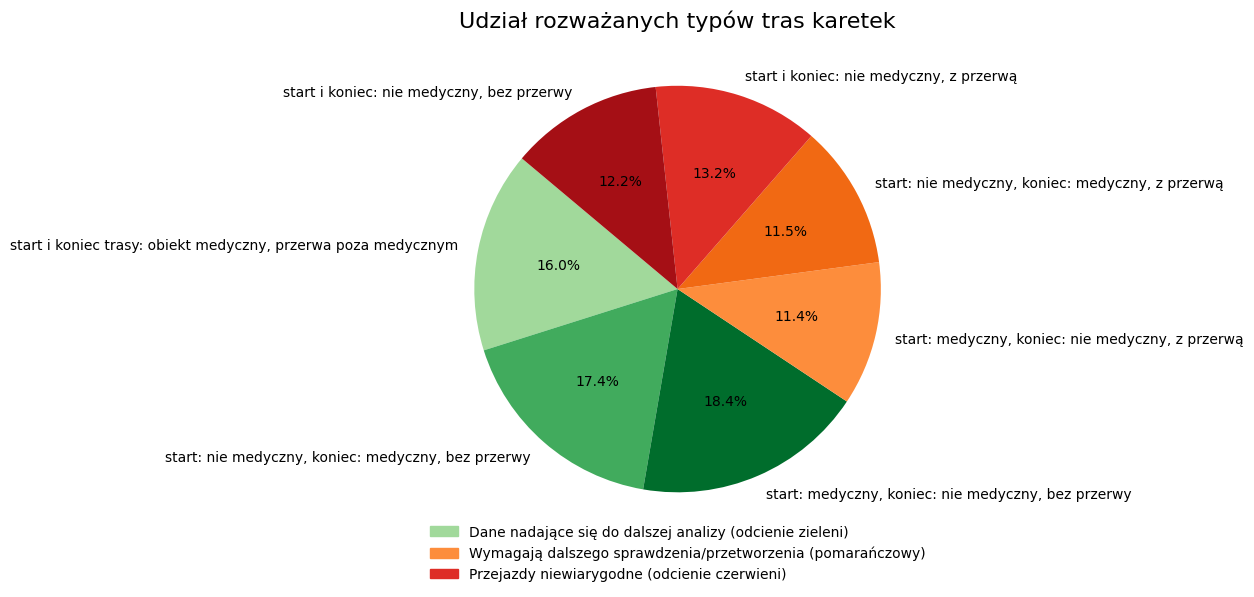

<Figure size 640x480 with 0 Axes>

In [120]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ratios = [
    med_to_med_with_break_ratio,
    non_med_to_med_wo_break_ratio,
    med_to_non_med_wo_break_ratio,
    med_to_non_med_w_break_ratio,
    non_med_to_med_w_break_ratio,
    non_med_to_non_med_w_break_ratio,
    non_med_to_non_med_wo_break_ratio
]

labels = [
    'start i koniec trasy: obiekt medyczny, przerwa poza medycznym',
    'start: nie medyczny, koniec: medyczny, bez przerwy',
    'start: medyczny, koniec: nie medyczny, bez przerwy',
    'start: medyczny, koniec: nie medyczny, z przerwą',
    'start: nie medyczny, koniec: medyczny, z przerwą',
    'start i koniec: nie medyczny, z przerwą',
    'start i koniec: nie medyczny, bez przerwy'
]

colors = [
    '#a1d99b',  # light green
    '#41ab5d',  # medium green
    '#006d2c',  # dark green
    '#fd8d3c',  # light orange
    '#f16913',  # dark orange
    '#de2d26',  # strong red
    '#a50f15'   # dark red
]

# Tworzenie wykresu
plt.figure(figsize=(12, 12))
plt.pie(ratios, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Udział rozważanych typów tras karetek', fontsize=16)
legend_patches = [
    mpatches.Patch(color='#a1d99b', label='Dane nadające się do dalszej analizy (odcienie zieleni)'),
    mpatches.Patch(color='#fd8d3c', label='Wymagają dalszego sprawdzenia/przetworzenia (pomarańczowy)'),
    mpatches.Patch(color='#de2d26', label='Przejazdy niewiarygodne (odcienie czerwieni)')
]


plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=10, frameon=False)
plt.tight_layout()
plt.show()
plt.savefig('trasy_karetek_rodzaje.png', dpi=300, bbox_inches='tight')